# PURPOSE

In [ ]:
'''
simply k-means on numeric data
'''
None

# IMPORTS

In [2]:
%run ipynb_setup.ipynb

In [6]:
%run class_def.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GET DATASET

In [5]:
d=Dataset()

In [6]:
d.raw.head(2) # raw data

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.0,14,EUR,100,0,3.76,54,26.0,...,568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.0,22,EUR,20000,1,3.45,6135,2269.0,...,17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08


In [7]:
d.df.head(2) # numeric data

,title,title_orig,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,tags,product_color,merchant_title,merchant_name,merchant_rating_count,merchant_rating,product_picture
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.0,14,100,3.76,54,26.0,8.0,10.0,1.0,9.0,"Summer,Fashion,womenunderwearsuit,printedpajam...",white,zgrdejia,zgrdejia,568,4.128521,https://contestimg.wish.com/api/webimage/5e9ae...
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.0,22,20000,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,"Mini,womens dresses,Summer,Patchwork,fashion d...",green,SaraHouse,sarahouse,17752,3.899673,https://contestimg.wish.com/api/webimage/58940...


# PREP DATA FOR K-MEANS

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# SCALE NUMERICAL DATA

### get

In [20]:
df_num = d.df.select_dtypes(include=['int64','float64'])
df_num

,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,merchant_rating_count,merchant_rating
0,16.00,14,100,3.76,54,26.0,8.0,10.0,1.0,9.0,568,4.128521
1,8.00,22,20000,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,17752,3.899673
2,8.00,43,100,3.57,14,5.0,4.0,2.0,0.0,3.0,295,3.989831
3,8.00,8,5000,4.03,579,295.0,119.0,87.0,42.0,36.0,23832,4.020435
4,2.72,3,100,3.10,20,6.0,4.0,2.0,2.0,6.0,14482,4.001588
...,...,...,...,...,...,...,...,...,...,...,...,...
1565,3.00,8,100,3.79,57,25.0,10.0,13.0,3.0,6.0,4080,3.987990
1567,8.00,7,20000,4.25,3127,1919.0,580.0,304.0,128.0,196.0,16803,4.155032
1568,6.00,9,10000,4.08,1367,722.0,293.0,185.0,77.0,90.0,5316,4.224605
1570,5.00,19,100,3.71,59,24.0,15.0,8.0,3.0,9.0,210,3.961905


In [32]:
df_num.describe()

,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,merchant_rating_count,merchant_rating
count,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1.341000e+03,1341.000000
mean,8.458218,23.819538,4820.662938,3.840127,981.858315,487.257274,197.757274,148.264931,70.121746,104.770291,2.787363e+04,4.040607
std,3.977299,30.512737,9947.731683,0.485037,2093.654152,1032.823719,421.996245,329.942369,160.212731,225.530005,8.357111e+04,0.202343
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.333333
25%,5.850000,7.000000,100.000000,3.580000,30.000000,17.000000,6.000000,5.000000,2.000000,4.000000,2.366000e+03,3.930573
50%,8.000000,10.000000,1000.000000,3.870000,209.000000,108.000000,42.000000,30.500000,15.000000,25.000000,8.740000e+03,4.048356
75%,11.000000,26.000000,5000.000000,4.120000,939.000000,468.500000,184.500000,146.500000,69.000000,109.000000,2.522200e+04,4.168097
max,49.000000,252.000000,100000.000000,5.000000,20744.000000,11548.000000,4152.000000,3658.000000,2003.000000,2789.000000,2.174765e+06,5.000000


### impute nans

In [21]:
df_num.isna().sum() # check nans

price                     0
retail_price              0
units_sold                0
rating                    0
rating_count              0
rating_five_count        35
rating_four_count        35
rating_three_count       35
rating_two_count         35
rating_one_count         35
merchant_rating_count     0
merchant_rating           0
dtype: int64

In [22]:
# look at rows with nans
d.raw.select_dtypes(include=['int64','float64']).loc[
    df_num[
        d.raw['rating_five_count'].isna()
    ].index
]

<ipython-input-22-8d422691dba5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num[


,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture
74,8.00,33,10,0,5.0,0,NaN,NaN,NaN,NaN,...,0,50,2,0,25,50,NaN,1496,4.169786,0
112,5.00,51,10,0,5.0,0,NaN,NaN,NaN,NaN,...,0,1,1,0,36,50,NaN,295,3.989831,0
126,2.72,9,1,0,5.0,0,NaN,NaN,NaN,NaN,...,0,1,1,0,33,50,NaN,378,3.597884,0
189,5.00,5,10,0,5.0,0,NaN,NaN,NaN,NaN,...,0,50,2,0,8,50,1.0,129,3.837209,0
216,11.00,30,10,0,5.0,0,NaN,NaN,NaN,NaN,...,0,50,3,0,78,50,1.0,22621,4.295124,0
248,8.00,9,7,0,5.0,0,NaN,NaN,NaN,NaN,...,0,5,3,0,38,50,NaN,108048,4.052504,1
309,4.81,5,100,1,5.0,0,NaN,NaN,NaN,NaN,...,0,5,1,0,47,50,1.0,6,4.333333,0
346,8.00,7,10,1,5.0,0,NaN,NaN,NaN,NaN,...,0,50,3,0,10,50,NaN,27175,3.966035,0
348,11.00,30,1,0,5.0,0,NaN,NaN,NaN,NaN,...,0,10,2,0,33,50,NaN,1380,4.007246,0
375,8.00,17,10,0,5.0,0,NaN,NaN,NaN,NaN,...,0,50,3,0,48,50,1.0,8,3.625000,0


##### manually impute

In [9]:
mean_values=df_num.mean(axis=0) # populate nans with mean
mean_values

price                        8.458218
retail_price                23.819538
units_sold                4820.662938
rating                       3.840127
rating_count               981.858315
rating_five_count          487.257274
rating_four_count          197.757274
rating_three_count         148.264931
rating_two_count            70.121746
rating_one_count           104.770291
merchant_rating_count    27873.629381
merchant_rating              4.040607
dtype: float64

In [10]:
df_num = df_num.fillna(mean_values)

##### sklearn impute

In [11]:
from sklearn.impute import SimpleImputer

In [13]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean') # impute with mean
imputed = imp.fit_transform(df_num)
imputed

array([[1.60000000e+01, 1.40000000e+01, 1.00000000e+02, ...,
        9.00000000e+00, 5.68000000e+02, 4.12852113e+00],
       [8.00000000e+00, 2.20000000e+01, 2.00000000e+04, ...,
        1.07700000e+03, 1.77520000e+04, 3.89967328e+00],
       [8.00000000e+00, 4.30000000e+01, 1.00000000e+02, ...,
        3.00000000e+00, 2.95000000e+02, 3.98983051e+00],
       ...,
       [6.00000000e+00, 9.00000000e+00, 1.00000000e+04, ...,
        9.00000000e+01, 5.31600000e+03, 4.22460497e+00],
       [5.00000000e+00, 1.90000000e+01, 1.00000000e+02, ...,
        9.00000000e+00, 2.10000000e+02, 3.96190476e+00],
       [7.00000000e+00, 6.00000000e+00, 1.00000000e+02, ...,
        2.00000000e+00, 7.02300000e+03, 4.23593906e+00]])

In [23]:
df_num_imputed = pd.DataFrame(imputed,index=df_num.index,columns=df_num.columns)
df_num_imputed.isna().sum() # check no more nans

price                    0
retail_price             0
units_sold               0
rating                   0
rating_count             0
rating_five_count        0
rating_four_count        0
rating_three_count       0
rating_two_count         0
rating_one_count         0
merchant_rating_count    0
merchant_rating          0
dtype: int64

### scale

In [38]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_num_imputed)

In [28]:
df_num_imputed_scaled = pd.DataFrame(scaled_features, index=df_num.index, columns=df_num.columns)

In [29]:
df_num_imputed_scaled.describe()

,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,merchant_rating_count,merchant_rating
count,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03,1.341000e+03
mean,9.587161e-17,4.139534e-18,-1.937302e-17,-5.785827e-16,1.283256e-17,-1.303953e-17,-2.082186e-17,-3.969813e-17,-2.264325e-17,3.038418e-17,-2.164976e-17,-7.699533e-18
std,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00,1.000373e+00
min,-1.875896e+00,-7.481483e-01,-4.846794e-01,-5.857665e+00,-4.691437e-01,-4.782349e-01,-4.750431e-01,-4.555221e-01,-4.436749e-01,-4.709155e-01,-3.336563e-01,-8.440686e+00
25%,-6.560208e-01,-5.514357e-01,-4.747237e-01,-5.365026e-01,-4.548093e-01,-4.615497e-01,-4.582280e-01,-4.401604e-01,-4.246932e-01,-4.484418e-01,-3.053345e-01,-5.440027e-01
50%,-1.152513e-01,-4.530794e-01,-3.842171e-01,6.161252e-02,-3.692810e-01,-3.604569e-01,-3.645441e-01,-3.510621e-01,-3.424395e-01,-3.540522e-01,-2.290357e-01,3.830966e-02
75%,6.393109e-01,7.148739e-02,1.803466e-02,5.772290e-01,-2.047822e-02,0.000000e+00,0.000000e+00,-8.732151e-17,-8.991503e-17,0.000000e+00,-3.174086e-02,6.303079e-01
max,1.019710e+01,7.480994e+00,9.571513e+00,2.392199e+00,9.442588e+00,1.085593e+01,9.498693e+00,1.078314e+01,1.222972e+01,1.206492e+01,2.569898e+01,4.743198e+00


### check no nans 

In [33]:
df_num_imputed_scaled.isna().sum() # ensure no more nans

price                    0
retail_price             0
units_sold               0
rating                   0
rating_count             0
rating_five_count        0
rating_four_count        0
rating_three_count       0
rating_two_count         0
rating_one_count         0
merchant_rating_count    0
merchant_rating          0
dtype: int64

# APPLY K-MEANS
- partitional clustering
- hierarchical clustering / agglomerative vs divisive
- density-based clustering

### figure out best `k` to use

In [36]:
# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(scaled_features)
    sse[k] = kmeans.inertia_

<AxesSubplot:>

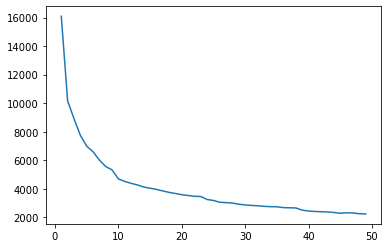

In [37]:
pd.Series(sse).plot() # see how residual decays with increasing `k`, looks like 10 groups is pretty good

### do fit for single `k`

In [45]:
kmeans = KMeans(
    init         = "random",
    n_clusters   = 15,
    n_init       = 10,
    max_iter     = 300,
    random_state = 42
)

In [46]:
kmeans.fit(df_num_imputed_scaled) # apply kmeans on scaled features cos kmeans metric sensitive to scale

KMeans(init='random', n_clusters=15, random_state=42)

In [47]:
kmeans.labels_ # predictions

array([ 0, 14,  9, ...,  1,  9, 11])

In [48]:
pd.Series(kmeans.labels_).unique()

array([ 0, 14,  9,  8, 10, 12,  3,  4,  7,  1, 11,  2,  6,  5, 13])

In [44]:
df_num_imputed_scaled.shape

(1341, 12)

In [49]:
len(pd.Series(kmeans.labels_).unique())

15

# REPEAT WITH PIPELINE

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

### [figure out best `k` to use] Impute

<AxesSubplot:>

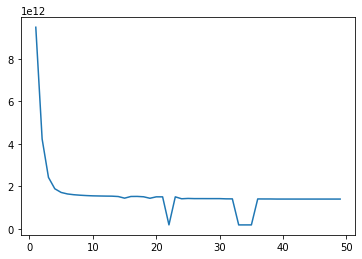

In [61]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()

### [figure out best `k` to use] Impute + StandardScaler

<AxesSubplot:>

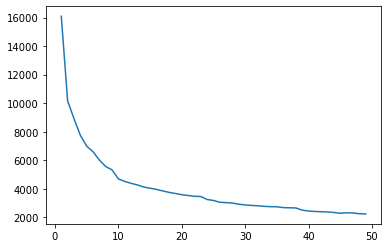

In [59]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()

### [figure out best `k` to use] Impute + StandardScaler + PCA

<AxesSubplot:>

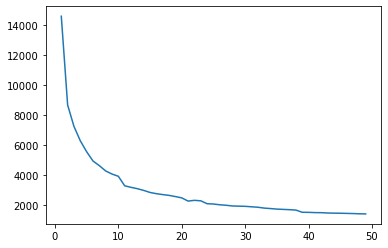

In [65]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
    PCA(n_components=5),
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()

### [figure out best `k` to use] Impute + StandardScaler + MinMaxScaler

<AxesSubplot:>

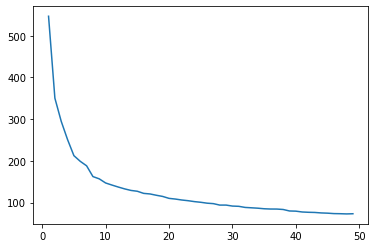

In [64]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
    MinMaxScaler(feature_range=(-1,1)), # consider apply minmax scaler on 1 sd of the data as well smooth outliers
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()

### [figure out best `k` to use] Impute + StandardScaler + MinMaxScaler + PCA

<AxesSubplot:>

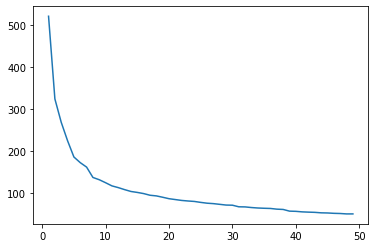

In [60]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
    MinMaxScaler(feature_range=(-1,1)), # consider apply minmax scaler on 1 sd of the data as well smooth outliers
    PCA(n_components=5),
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()